In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q medmnist
!pip install -q git+https://github.com/tensorflow/docs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import medmnist
from medmnist import INFO
import medmnist_loader
from medmnist_loader import get_loader

import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow_docs.vis import embed
import tensorflow as tf
import numpy as np
import imageio

In [ ]:
def transform_to_numpy(dataset):

    X, y = [], []
    for img, label in dataset:
        img = np.array(img)
        X.append(img)
        y.append(label)

    y = np.array(y).reshape((-1,))
    y = keras.utils.to_categorical(y)
    X = np.array(X).reshape((-1, 28, 28, 1))
    return X / 255, y

In [ ]:
info = INFO['breastmnist']
DataClass = getattr(medmnist_loader, info['python_class'])

n_channels = info['n_channels']
n_classes = len(info['label'])

X_train, y_train = transform_to_numpy(DataClass(split='train', download=True))
X_val, y_val = transform_to_numpy(DataClass(split='val', download=True))
X_test, y_test = transform_to_numpy(DataClass(split='test', download=True))

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


In [ ]:
X_train.shape

(546, 28, 28, 1)

In [ ]:
batch_size = 32
num_channels = 1
num_classes = 2
image_size = 28
latent_dim = 128

In [ ]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

130 3


In [ ]:
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((28, 28, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(7 * 7 * generator_in_channels),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [ ]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [ ]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

In [ ]:
history = cond_gan.fit(x=X_train, y=y_train, epochs=1000)

Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


18/18 [==============================] - 7s 231ms/step - g_loss: 0.7261 - d_loss: 0.6776
Epoch 2/1000
18/18 [==============================] - 5s 249ms/step - g_loss: 0.7280 - d_loss: 0.6394
Epoch 3/1000
18/18 [==============================] - 3s 187ms/step - g_loss: 0.9317 - d_loss: 0.4780
Epoch 4/1000
18/18 [==============================] - 2s 92ms/step - g_loss: 0.5309 - d_loss: 1.2631
Epoch 5/1000
18/18 [==============================] - 2s 90ms/step - g_loss: 0.8489 - d_loss: 0.8408
Epoch 6/1000
18/18 [==============================] - 2s 108ms/step - g_loss: 1.1258 - d_loss: 0.5309
Epoch 7/1000
18/18 [==============================] - 2s 102ms/step - g_loss: 1.6132 - d_loss: 0.2836
Epoch 8/1000
18/18 [==============================] - 2s 88ms/step - g_loss: 0.9227 - d_loss: 0.6208
Epoch 9/1000
18/18 [==============================] - 2s 89ms/step - g_loss: 0.4402 - d_loss: 1.0548
Epoch 10/1000
18/18 [==============================] - 2s 88ms/step - g_loss: 0.6811 - d_loss: 0.67

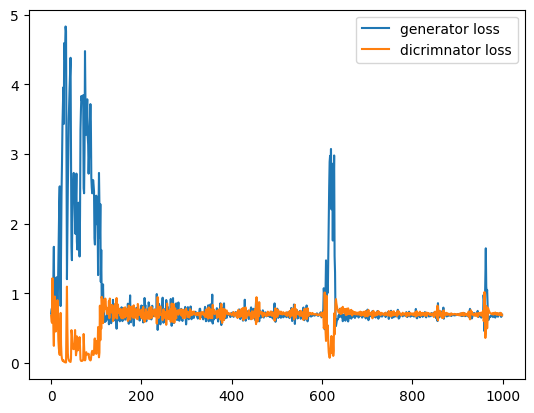

In [ ]:
plt.plot(history.history['g_loss'], label='generator loss')
plt.plot(history.history['d_loss'], label='dicrimnator loss')
plt.legend()
plt.show()

In [ ]:
noise = np.random.normal(size=(4000, generator_in_channels))
noise[:2000, -2] = 1
noise[:2000, -1] = 0
noise[2000:, -2] = 0
noise[2000:, -1] = 1

In [ ]:
gen_data = result = cond_gan.generator.predict(noise)

125/125 [==============================] - 1s 8ms/step


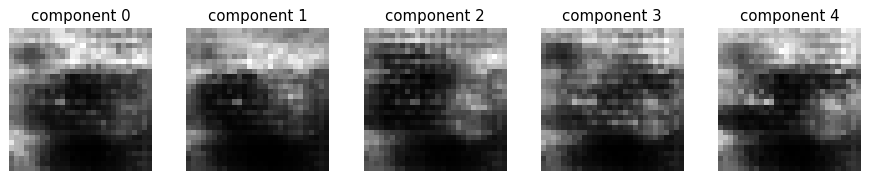

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(10, 2), dpi=90)
axes = axes.ravel()

for i in range(5):
    axes[i].imshow(gen_data[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'component {i}')

plt.tight_layout()
plt.show()

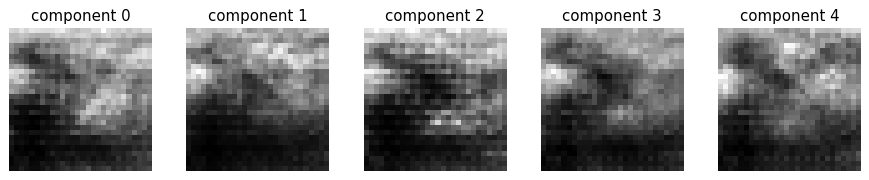

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(10, 2), dpi=90)
axes = axes.ravel()

for i in range(5):
    axes[i].imshow(gen_data[2000+i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'component {i}')

plt.tight_layout()
plt.show()

In [ ]:
X_train_reshaped = np.repeat(X_train, 3, axis=3)
X_train_reshaped = np.pad(X_train_reshaped, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant', constant_values=0.0)

In [ ]:
resnet1 = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet", input_shape=(32, 32, 3))

input_layer = tf.keras.layers.Input(shape=(32, 32, 3))
x = resnet1(input_layer)
x = tf.keras.layers.Dense(2)(x)
x = tf.keras.layers.Softmax()(x)

model1 = tf.keras.models.Model(inputs=input_layer, outputs=x)
model1.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
hist1 = model1.fit(X_train_reshaped, y_train, epochs=10)

Epoch 1/10
18/18 [==============================] - 13s 720ms/step - loss: 1.2815
Epoch 2/10
18/18 [==============================] - 13s 722ms/step - loss: 0.7853
Epoch 3/10
18/18 [==============================] - 13s 721ms/step - loss: 1.0322
Epoch 4/10
18/18 [==============================] - 13s 724ms/step - loss: 0.8764
Epoch 5/10
18/18 [==============================] - 13s 723ms/step - loss: 0.8134
Epoch 6/10
18/18 [==============================] - 13s 717ms/step - loss: 0.7317
Epoch 7/10
18/18 [==============================] - 100s 6s/step - loss: 0.7195
Epoch 8/10
18/18 [==============================] - 13s 732ms/step - loss: 0.7168
Epoch 9/10
18/18 [==============================] - 13s 735ms/step - loss: 0.7335
Epoch 10/10
18/18 [==============================] - 13s 733ms/step - loss: 0.7576


In [ ]:
np.count_nonzero(y_train[:, 0] == 0) - np.count_nonzero(y_train[:, 0] == 1)

252

In [ ]:
X_train_new = np.concatenate([X_train, gen_data[:252]], axis=0)

In [ ]:
X_train_new.shape

(798, 28, 28, 1)

In [ ]:
gen_labels = np.zeros((252, 2))
gen_labels[:, 0] = 1
y_train_new = np.concatenate([y_train, gen_labels], axis=0)

In [ ]:
y_train_new.shape

(798, 2)

In [ ]:
np.count_nonzero(y_train_new[:, 0] == 0) - np.count_nonzero(y_train_new[:, 0] == 1)

0